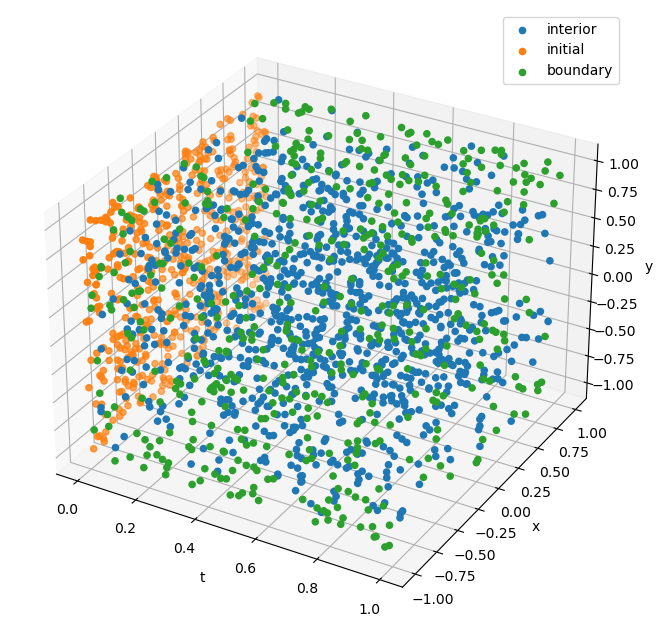

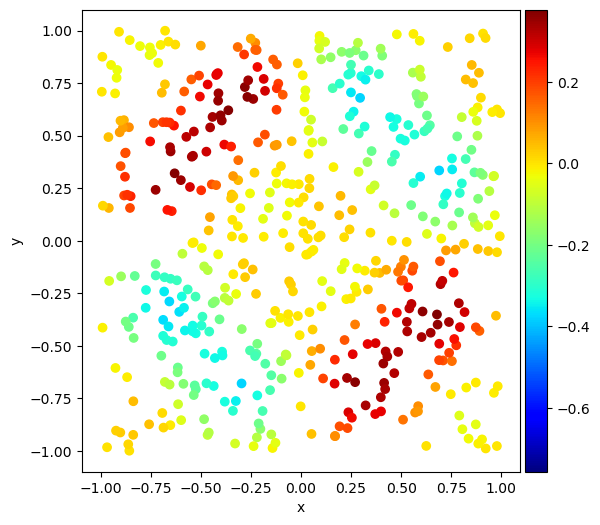

In [12]:
%matplotlib inline
from typing import Optional
import numpy as np
import torch 
import torch.nn as nn
from torch.nn.parameter import Parameter 
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

"""
    two tasks:
    1. g(x,y,mu) = u(T, x, y, mu)
    2. G(u0)(x,y) = u(T,x,y)
"""
PI = np.pi
def uniform(a, b, size):
    return (b-a)*torch.rand(size=size) + a
def grad(output, input):
    return torch.autograd.grad(output, input, create_graph=True)[0]
def mse(output, target):
    return ((output - target)**2).mean()

class MLP(nn.Module):
    """
    Multi-Layer Perceptron

    Usage:
        >>> mlp = MLP(2, 1, 32, 3)
        >>> x = torch.randn(10, 2)
        >>> y = mlp(x)
        >>> y.shape
        torch.Size([10, 1])
    """
    def __init__(self,
                 input_size,
                 output_size,
                 hidden_size,
                 num_layers,
                 activation=nn.Tanh):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation = activation

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, self.hidden_size))
        for _ in range(self.num_layers - 2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.layers.append(nn.Linear(self.hidden_size, self.output_size))

        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            gain = nn.init.calculate_gain(self.activation.__name__)
            nn.init.xavier_normal_(layer.weight, gain=gain)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class DeepONet(nn.Module):
    def __init__(self):
        self.Weight = MLP(2, 1, 32, 3)
        self.Basis  = MLP(2, 1, 32, 3)
        self.reset_parameters()
    def reset_parameters(self):
        self.Weight.reset_parameters()
        self.Basis.reset_parameters()
    def forward(self, weight, basis):
        """
            Parameters:
            -----------
                weight: [N_points, 1]
                basis:  [N_basis, u_dim] u_dim can only be 1, as the output is a scalar matrix
            Returns:
            --------
                output: [N_points, N_basis]
        """
        raise NotImplementedError()
        weight = self.Weight(weight)
        basis  = self.Basis(basis)

class FNO(nn.Module):
    """
    Fourier Neural Operator
    """
    def __init__(self):
        raise NotImplementedError() 

class CNO(nn.Module):
    def __init__(self):
        raise NotImplementedError()

class HeatEquation:
    """
        Heat Equation
        PDE:
            du_dt = d^2u_dx^2 + d^2u_dy^2, -1 <= x,y <= 1, 0 <= t <= T, -1^d <= mu <= 1^d
            mu \sim Uniform(-1,1)^d
        Initial Condition:
            u(0, x, y, mu) = - 1/ d \sum_{m=1}^d mu_m * sin(pi * m * x) * sin(pi * m * y) / sqrt(m)
        Boundary Condition:
            u(t, {-1,1}, {-1,1}, mu) = 0
    """
    def __init__(self, d = 1, T = 1.0):
        self.d = d
        self.T = T

        self.t_dim = 0 
        self.x_dim = 1  
        self.y_dim = 2
        # mu              [d]
        # interior_points [N_interior, 3]
        # initial_points  [N_initial, 3]
        # boundary_points [N_boundary, 3]
        # initial_value   [N_initial, 1]
        self.mu = uniform(-1, 1, size=(self.d,))
        self.interior_points, self.initial_points, self.boundary_points = self.sample_points()

        m = torch.arange(1, self.d+1).float()[None,:]
        x, y = self.initial_points[:,1:2], self.initial_points[:,2:3]
        self.initial_u = -1 / d * (self.mu * torch.sin(PI * m * x) * torch.sin(PI * m * y) / torch.sqrt(m)).sum(-1, keepdim=True)

    def exact_solution(self, t, x, y):
        raise NotImplementedError()

    def sample_points(self):
        N_interior = 1024
        N_boundary = 512
        N_initial  = 512
        t_dim, x_dim = 0, (1,2)

        interior_points = torch.zeros(N_interior, 3)
        interior_points[:,t_dim] = uniform(0, self.T, size=(N_interior,))
        interior_points[:,x_dim] = uniform(-1, 1, size=(N_interior,2))
        initial_points = torch.zeros(N_initial, 3)
        initial_points[:,x_dim] = uniform(-1, 1, size=(N_initial,2))
        boundary_points = torch.zeros(N_boundary, 3)
        boundary_points[:,t_dim] = uniform(0, self.T, size=(N_boundary,))
        boundary_points[:,x_dim] = uniform(-1, 1, size=(N_boundary,2))
        boundary_points[:N_boundary//4,1] = -1
        boundary_points[N_boundary//4:2*N_boundary//4,1] = 1
        boundary_points[2*N_boundary//4:3*N_boundary//4,2] = -1
        boundary_points[3*N_boundary//4:,2] = 1

        # TODO: observation points with exact solution
        
        return interior_points, initial_points, boundary_points
    
    def plot_points(self):
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": "3d"})
        ax.scatter(self.interior_points[:,0], self.interior_points[:,1], self.interior_points[:,2], label='interior', alpha=1)
        ax.scatter(self.initial_points[:,0], self.initial_points[:,1], self.initial_points[:,2], label='initial')
        ax.scatter(self.boundary_points[:,0], self.boundary_points[:,1], self.boundary_points[:,2], label='boundary', alpha=1)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel('x')
        ax.set_zlabel('y')
        plt.show()

    def plot_initial(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        x, y, z = self.initial_points[:,1], self.initial_points[:,2], self.initial_u[:,0]
        h = ax.scatter(x, y, c=z, vmin=z.min() * 2, cmap=cm.jet)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(h, cax=cax, orientation='vertical')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.show()

    def physics_loss(self, u_interior):
        du_dx = grad(u_interior, self.interior_points)[:,self.x_dim]
        d2u_dx2 = grad(du_dx, self.interior_points)[:,self.x_dim]
        du_dy = grad(u_interior, self.interior_points)[:,self.y_dim]
        d2u_dy2 = grad(du_dy, self.interior_points)[:,self.y_dim]
        du_dt = grad(u_interior, self.interior_points)[:,self.t_dim]
        return mse(d2u_dx2 + d2u_dy2, du_dt)
    
    def boundary_loss(self, u_boundary):
        return mse(u_boundary, torch.zeros_like(u_boundary))
    
    def initial_loss(self, u_initial):
        return mse(u_initial, self.initial_u)

    def loss(self, compute_u):
        u_interior = compute_u(self.interior_points)[:,0]
        u_boundary = compute_u(self.boundary_points)[:,0]
        u_initial  = compute_u(self.initial_points)[:,0]
        return self.physics_loss(u_interior) + self.boundary_loss(u_boundary) + self.initial_loss(u_initial)



def pinn_fit():
    equation = HeatEquation(d=2)
    epoch = 1000
    model = MLP(3, 1, 32, 3)
    losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_loss, best_weight = float('inf'), None
    p = tqdm(range(epoch), desc="Adam", colour="blue")

    for _ in p:
        optimizer.zero_grad()
        loss = equation.loss(model)
        loss.backward()
        optimizer.step()
        if  loss.item() < best_loss:
            best_loss = loss.item()
            best_weight = model.state_dict()
        losses.append(loss.item())
        p.set_postfix({'loss': best_loss})

    p.close()
    model.load_state_dict(best_weight)

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=0.5,
        max_iter=50000,
        max_eval=50000,
        history_size=50,
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe",
    )
    
    p = tqdm(total=50000, desc="LBFGS", colour="green")

    def closure():
        optimizer.zero_grad()
        loss = equation.loss(model)
        loss.backward()
        p.update(1)
        p.set_postfix({'loss': loss.item()})
        losses.append(loss.item())
        return loss
    
    optimizer.step(closure)

    p.close()
    model.eval()
    torch.save(model.state_dict(), 'pinn.pth')

    # plot loss 
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(losses)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    plt.show()

    # plot prediction
    with torch.no_grad():
        u_interior = model(equation.interior_points, subplot_kw={"projection": "3d"})
    fig, ax = plt.subplots(figsize=(6, 6))
    h = ax.scatter(equation.interior_points[:,0], equation.interior_points[:,1], equation.interior_points[:,2], c=u_interior[:, 0], cmap=cm.jet)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(h, cax=cax, orientation='vertical')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    plt.show()

    

def deeponet_fit():
    raise NotImplementedError()

def fno_fit():
    raise NotImplementedError() 

def cno_fit():
    raise NotImplementedError()

he = HeatEquation(d=2)
he.plot_points()
he.plot_initial()